In [3]:
# Filter warnings for readability
import warnings
warnings.filterwarnings('ignore')

Imports & Config

In [1]:
import pandas as pd
from transformers import pipeline
import numpy as np
from sklearn.model_selection import train_test_split
import spacy
import torch
import yaml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, roc_curve, auc

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)


c:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0708 23:00:30.259000 55984 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version PyTorch was built with:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
    print("GPU Opt: ", config['use_available_gpus'] )

PyTorch version: 2.7.1+cu118
CUDA version PyTorch was built with: 11.8
Is CUDA available: True
CUDA device: Quadro P2000 with Max-Q Design
GPU Opt:  True


Read in Dataset

In [4]:
events_df = pd.read_csv('Nat Cat Events.csv')

Only Consider Titles

In [5]:
titles = events_df['title']

### __Step 1__: Remove *duplicates*, *null values* & *whitespaces*

In [6]:
titles = titles.drop_duplicates().reset_index(drop=True)

In [7]:
titles = titles.dropna().reset_index(drop=True)

In [8]:
titles_df = pd.DataFrame(titles)

In [9]:
titles_df["title"] = titles_df["title"].str.strip()

In [10]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65158 entries, 0 to 65157
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   65158 non-null  object
dtypes: object(1)
memory usage: 509.2+ KB


### __Step 2__: Find articles containing a *location*.

Select NLP Pipeline depending on hardware availability


`en_core_web_try`: Uses a Transformer for word & context embeddings


`en_core_web_sm`: Token-to-Vector (Tok2Vec) based pipeline uses CNN's or LSTM's for work & context embeddings

See documentation [here](https://spacy.io/models/en#benchmarks)


In [11]:
if torch.cuda.is_available() and config['use_available_gpus']:
    spacy.require_gpu() # Use GPU
    nlp = spacy.load(config['ner_pipeline_gpu'])
    batch_size = config['batch_size_gpu']
    print("Using trf (GPU Supported)")
else:
    nlp = spacy.load(config['ner_pipeline_cpu']) # Use CPU
    batch_size = config['batch_size_cpu']
    print("Using sm")

Using trf (GPU Supported)


##### Find articles where the titles match the following criteria using *SpaCy* a *NLP* module for *Named-Entity-Recognition*
- Contains a geopolitical entity like a country, city or state (Entity GPE) OR
- Contains a Non-GPE location like a mountain or body of water (Entity LOC)

Entities are taken from the [OntoNotes5](https://catalog.ldc.upenn.edu/LDC2013T19) dataset which many english models are built on

In [ ]:
docs = list(nlp.pipe(titles_df['title'].values, batch_size=batch_size))
#titles_df['occurrence_and_location'] = [any(ent.label_ in ("DATE", "TIME") for ent in doc.ents) and any(ent.label_ in ("GPE", "LOC") for ent in doc.ents) for doc in docs]
titles_df['has_location'] = [any(ent.label_ in ("GPE", "LOC") for ent in doc.ents) for doc in docs]

In [ ]:
# Free up CUDA Cores
if config['use_available_gpus']:
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [14]:
titles_df.to_csv('titles_containing_locations.csv', index = False)

In [2]:
titles_df = pd.read_csv('titles_containing_locations.csv')
titles_location_df = titles_df[titles_df['has_location']]

In [3]:
titles_location_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40989 entries, 0 to 65156
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         40989 non-null  object
 1   has_location  40989 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 680.5+ KB


### __Step 3__: Use a *Zero-Shot-Classifier* to capture confidence of a title implying a *natural catastrophe event*

In [4]:
labels = ["natural catastrophe event that has occurred"]

if torch.cuda.is_available() and config['use_available_gpus']:
    print("Using GPU")
    classifier = pipeline("zero-shot-classification", model=config['zero_shot_model_gpu'], device=0) # Use GPU
    results = classifier(titles_location_df['title'].tolist(), candidate_labels=labels, batch_size=config['batch_size_gpu'])
else:
    print("Using CPU")
    classifier = pipeline("zero-shot-classification", model=config['zero_shot_model_cpu'], device=-1) # Use CPU
    results = classifier(titles_location_df['title'].tolist(), candidate_labels=labels, batch_size=config['batch_size_cpu'])

Using GPU


c:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
titles_location_df['zero_shot_score'] = [zero_shot['scores'][0] for zero_shot in results]

C:\Users\james\AppData\Local\Temp\ipykernel_55984\765615976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles_location_df['zero_shot_score'] = [zero_shot['scores'][0] for zero_shot in results]


In [6]:
titles_location_df.to_csv('titles_zero_shot.csv', index=False)

In [7]:
# Free up CUDA Cores
del classifier
del results
if config['use_available_gpus']:
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

#### Analyse the Distribution of scores

<Axes: >

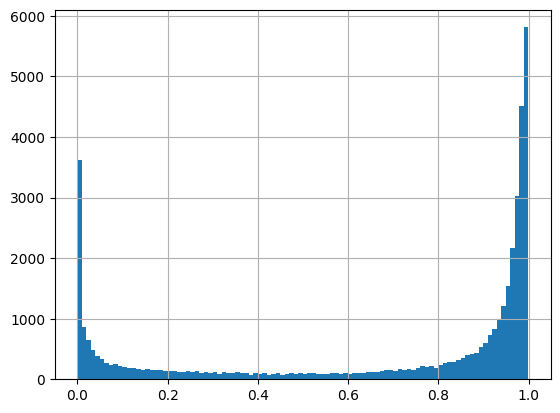

In [8]:
titles_location_df['zero_shot_score'].hist(bins=100)

From this histogram we can see that the Zero-Shot-Classifier is confident predicting a majority of titles (>0.9 or <0.1)

### __Step 4__: Build a Supervised Model to refine less confident Zero-Shot classifications
Let's get a second opinion on these less-confident classifications
- Take extremely confident predictions (>0.99 or <0.01) and use these titles for training

In [52]:
# Take rows of extremelt confident predictions
extemely_confident_df = titles_location_df[(titles_location_df['zero_shot_score'] > 0.99) | (titles_location_df['zero_shot_score'] < 0.01)]
less_confident_df = titles_location_df[(titles_location_df['zero_shot_score'] < 0.99) & (titles_location_df['zero_shot_score'] > 0.01)]
print("The number of confident Zero-Shot classifications: ", len(extemely_confident_df))
print("The number of Less confident Zero-Shot classifications: ", len(less_confident_df))

The number of confident Zero-Shot classifications:  9154
The number of Less confident Zero-Shot classifications:  31835


In [53]:
# Create binary label for training
extemely_confident_df['labels'] = np.where(extemely_confident_df['zero_shot_score'] > 0.99, 1, np.where(extemely_confident_df['zero_shot_score'] < 0.01, 0, np.nan)).astype(int)

C:\Users\james\AppData\Local\Temp\ipykernel_55984\2095714043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extemely_confident_df['labels'] = np.where(extemely_confident_df['zero_shot_score'] > 0.99, 1, np.where(extemely_confident_df['zero_shot_score'] < 0.01, 0, np.nan)).astype(int)


In [54]:
extemely_confident_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9154 entries, 12 to 65147
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            9154 non-null   object 
 1   has_location     9154 non-null   bool   
 2   zero_shot_score  9154 non-null   float64
 3   labels           9154 non-null   int32  
dtypes: bool(1), float64(1), int32(1), object(1)
memory usage: 259.2+ KB


In [55]:
extemely_confident_df = extemely_confident_df.reset_index(drop=True)

Using `title` as the independent variable and `labels` as the target variable

LR Model

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}

Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       722
           1       1.00      0.99      0.99      1109

    accuracy                           0.99      1831
   macro avg       0.99      0.99      0.99      1831
weighted avg       0.99      0.99      0.99      1831



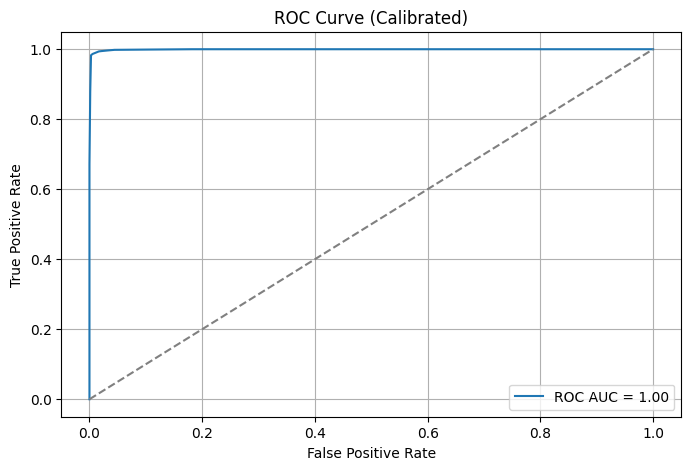

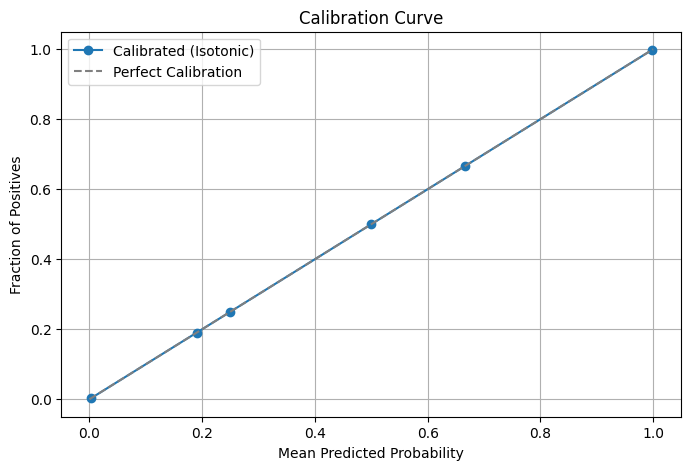

In [56]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    extemely_confident_df['title'], 
    extemely_confident_df['labels'], 
    test_size=0.2, 
    random_state=42, 
    stratify=extemely_confident_df["labels"]
)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Hyperparameter grid
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 3, 5],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

# Grid search
grid = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)
grid.fit(X_train, y_train)

# ✅ Calibrate with Isotonic Regression (fit on test set to avoid train leakage)
calibrated_clf = CalibratedClassifierCV(grid.best_estimator_, method='isotonic', cv='prefit')
calibrated_clf.fit(X_test, y_test)  # Fit calibration model on held-out test set

# Predict probabilities
y_proba_cal = calibrated_clf.predict_proba(X_test)[:, 1]
y_pred_cal = calibrated_clf.predict(X_test)

# Classification report
print("Best Parameters:", grid.best_params_)
print("\nClassification Report (Calibrated):")
print(classification_report(y_test, y_pred_cal))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_cal)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Calibrated)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ✅ Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated (Isotonic)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()


The LR Model performs very well on the test set

Therefore, let's use this model as a *second opinion* classification for the less confident rows.

- Infer on Less confident Zero-Shot classifications
- If the average of the inference propensity and Zero-Shot score is >0.5, include the row in the final preprocessed dataset

Infer

In [59]:
less_confident_df['propensity'] = calibrated_clf.predict_proba(less_confident_df['title'])[:,1]

C:\Users\james\AppData\Local\Temp\ipykernel_55984\686816750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_confident_df['propensity'] = calibrated_clf.predict_proba(less_confident_df['title'])[:,1]


In [60]:
less_confident_df['average_score'] = (less_confident_df['zero_shot_score'] + less_confident_df['propensity']) / 2

C:\Users\james\AppData\Local\Temp\ipykernel_55984\833842052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_confident_df['average_score'] = (less_confident_df['zero_shot_score'] + less_confident_df['propensity']) / 2


In [61]:
less_confident_df.head()

,title,has_location,zero_shot_score,propensity,average_score
0,2023 was a year of extreme weather in Southern...,True,0.789863,0.018519,0.404191
4,"Tornados , scorchers and ice storm : Top 10 we...",True,0.986209,0.666667,0.826438
11,Yellowstone Supervolcano Magma Chamber Is Very...,True,0.967409,0.250000,0.608705
16,DSWD DROMIC Report on the Tornado Incident in ...,True,0.986278,0.995671,0.990974
19,New state report : Wildfire smoke increased de...,True,0.964167,0.991453,0.977810


<Axes: >

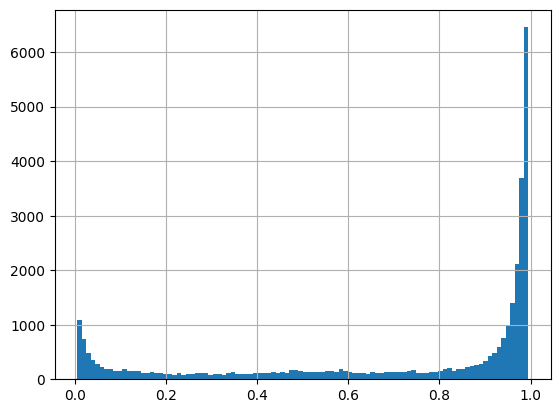

In [62]:
less_confident_df['average_score'].hist(bins=100)

Given this new ensemble model. The majority of classifications are above 0.85

In [75]:
preprocessed_df = pd.concat([less_confident_df[less_confident_df['average_score'] > 0.85]['title'], extemely_confident_df['title']])

In [80]:
preprocessed_df.info()

<class 'pandas.core.series.Series'>
Index: 27533 entries, 16 to 9153
Series name: title
Non-Null Count  Dtype 
--------------  ----- 
27533 non-null  object
dtypes: object(1)
memory usage: 430.2+ KB


In [79]:
preprocessed_df.to_csv('preprocessed_df.csv', index=False)